# Estimating Heat Waves and Urban Heat Island Intensity with Land Surface Temperature
This Jupyter Notebook demonstrates how to find Heat Wave periods and map Urban Heat Island (UHI), based on [Planet Land Surface Temperature](https://developers.planet.com/docs/planetary-variables/land-surface-temperature/).  We'll be using the [Statistics API](https://docs.sentinel-hub.com/api/latest/api/statistical/) and [SentinelHubRequest]() to perform this analysis.

<div style="width: 75%; padding: 15px; border: 2px solid #007980; border-radius: 5px; background-color: transparent; margin-left: 0;">
  <div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="display: flex; align-items: center; flex: 0 0 50%; padding-right: 20px;">
      <svg style="margin-right: 10px; fill: #007980; width: 64px; height: 64px;" viewBox="0 0 24 24">
        <path d="M11,9H13V7H11M12,20C7.59,20 4,16.41 4,12C4,7.59 7.59,4 12,4C16.41,4 20,7.59 20, 12C20,16.41 16.41,20 12,20M12,2A10,10 0 0,0 2,12A10,10 0 0,0 12,22A10,10 0 0,0 22,12A10, 10 0 0,0 12,2M11,17H13V11H11V17Z"></path>
      </svg>
      <p style="font-size: 16px; margin: 0; line-height: 1.5;">
        This notebook makes use of <a href="https://collections.sentinel-hub.com/planet-sandbox-data/" target="_blank">Planet Sandbox Data</a>. You need a Planet account in order to access this data. If you don't already have an account, you can <a href="https://www.sentinel-hub.com/create_account/" target="_blank">create a free 30 day trial</a>. Please note that only 10 years of data are freely available in the Sandbox, while access to our full 20-year archive requires a purchase.
      </p>
    </div>
    <div style="flex: 0 0 50%; display: flex; justify-content: center; align-items: center;">
      <a href="https://www.sentinel-hub.com/create_account/" target="_blank" style="
        display: inline-block;
        padding: 10px 20px;
        font-size: 16px;
        font-weight: bold;
        color: #fff;
        background-color: #007980;
        border-radius: 5px;
        text-decoration: none;
        white-space: nowrap;
        transition: background-color 0.3s ease;
        margin: 0 auto;
      " onmouseover="this.style.backgroundColor='#005960'" onmouseout="this.style.backgroundColor='#007980'">
        Start Free Trial
      </a>
    </div>
  </div>
</div>

In [13]:
import json
import pandas as pd
import numpy as np
import getpass
import folium

import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

import sentinelhub
from sentinelhub import (
    SHConfig,
    Geometry,
    CRS,
    SentinelHubRequest,
    MimeType,
    DataCollection,
    SentinelHubStatistical,
    SentinelHubDownloadClient,
)


### Credentials

The Sentinel Hub Python SDK requires a ```client_id``` and a ```client_secret``` which can be created in the [Dashboard app user settings](https://apps.sentinel-hub.com/dashboard/#/account/settings). You can find full instructions on setting up the client credentials in this SDK from the [SDK documentation](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). The following code will check if you have a local profile already created, and if not it will ask for the credentials and save the profile.

In [3]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
    config.sh_client_id = getpass.getpass("Client ID: ")
    config.sh_client_secret = getpass.getpass("Client Secret: ")
    config.save()
    print(f"Credentials saved to {SHConfig.get_config_location()}")
else:
    print(f"Connected to Sentinel Hub")

Connected to Sentinel Hub


### Define field of interest

In this example a city of interest has been selected in France: Bordeaux. The boundary is defined as a GeoJSON file in EPSG:4326. We will read the GeoJSON and plot the area of interest.

In [4]:
# Read a geojson containing a polygon representing the city of Bordeaux, France, lateron bucket shapefiles
with open("bordeaux.geojson") as file:
    json_file = json.load(file)
# Load GeoJSON into a shapely polygon
polgyon = Polygon(json_file["features"][0]["geometry"]["coordinates"][0][0])
# Convert shapely polygon to a Sentinel Hub geometry
aoi = Geometry(polgyon, crs=CRS(4326)) # CRS 4326 (latitude and longitude) is WGS84 (longitude and latitude), reverse in case of error

In [5]:
# Plot the field on an interactive map
m = folium.Map(
    location=[
        polgyon.centroid.coords.xy[1][0],
        polgyon.centroid.coords.xy[0][0],
    ],
    zoom_start=12,
    tiles="OpenStreetMap",
)
geo_j = folium.GeoJson(data=polgyon, style_function=lambda x: {"fillColor": "blue"})
geo_j.add_to(m)
m

### Set collection IDs

[Land Surface Temperature](https://developers.planet.com/docs/planetary-variables/land-surface-temperature/) is available through the [Subscriptions API](https://developers.planet.com/docs/subscriptions/pvs-subs/). Once the area of interest and variables are subscribed to, the data is automatically delivered into an imagery collection on Planet Insights Platform if you use the Sentinel Hub delivery option.

In this example, we will use the Land Surface Temperature collection already available in [https://collections.sentinel-hub.com/land-surface-temperature/sandbox-data.html](https://collections.sentinel-hub.com/land-surface-temperature/sandbox-data.html).

For more information on how to call a collection ID in a request with Python, you can refer to the `sentinelhub-py` [documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html#Retrieve-data-from-collection).

In [6]:
collection_100m= "8d977093-cf9e-4351-8159-90f2522c29c1"
collection_1km= "6b613b07-410a-4312-93ad-d1751fdc55de"

# 1. Temporal analysis: Heatwave detection

## 1.1 Data extraction and preparation

Land Surface Temperature data is available twice a day: at 1330 and 0130.  We will generate a time series for the average of the these two measurements using Sentinel Hub Statistics API.  

We will perform the calculation with the following parameters:

- The Sandbox Data collection Land Surface Temperature `(data_collection)`
- Cumulative calculation from January 1st, 2013 to April 30th, 2023
- At the native resolution (0.01 degree -> ±1km)
- Calculated for each day `(P1D)`
- Over the geometry our city of interest `(aoi)`

In [7]:
def get_time_series(temp_extreme : str,
                    time_of_interest : tuple,
                    input_data : sentinelhub.api.base_request.InputDataDict,
                    parcel_geo : sentinelhub.geometry.Geometry,
                    config : sentinelhub.config.SHConfig) -> pd.Series:

    """Get time series of LST data from sentinel hub statstics API and addjust to daily temperature extreme"""

    # set parameters for max or min temperature calculation
    if temp_extreme == 'max':
        sensing_time = '"1330"'
        local_time = '13:30:00'

    if temp_extreme == 'min':
        sensing_time= '"0130"'
        local_time = '1:30:00'


    # eval script for getting time series and adjusting to daily temperature extreme
    time_series_evalscript = f"""
    //VERSION=3

    function setup() {{
        return {{
            input: [{{bands: ["LST", "dataMask"]}}],
            output: [
                {{ id: "LST", bands: 1, sampleType: "FLOAT32" }},
                {{ id: "dataMask", bands: 1, sampleType: "UINT8" }}
            ],
            mosaicking: "TILE"
        }};
    }}

    // Filter out scenes where the sensing time matches specified sensing time
    function preProcessScenes (collections) {{
        collections.scenes.tiles = collections.scenes.tiles.filter(function (tile) {{
            return tile.dataPath.includes("T"+{sensing_time});
        }})
        collections.scenes.tiles.sort((a, b) => new Date(b.date) - new Date(a.date));
        return collections
    }}

    // Convert Land Surface Temperature to celcius and apply linear regression
    function evaluatePixel(samples) {{

        var sample = samples[0].LST
        var nodata = samples[0].dataMask

        //convert to celcius
        var celcius = (sample / 100) - 273.5

        return {{
            LST: [celcius],
            dataMask: [nodata]
        }};
    }}
    """

    # Set up Sentinel Hub request
    request = SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(evalscript=time_series_evalscript,
                                                       time_interval=time_of_interest,
                                                       aggregation_interval="P1D",
                                                       resolution=(0.01, 0.01)),
                                                       input_data=[input_data],
                                                       geometry=parcel_geo,
                                                       config=config,
                                                        )

    # Make request and download response
    download_requests = [request.download_list[0]]
    client = SentinelHubDownloadClient(config=config)
    response = client.download(download_requests)

    # Format response into Pandas dataframe
    series = pd.json_normalize(response[0]["data"])
    series['date'] = pd.to_datetime(series['interval.from']) + pd.to_timedelta(local_time)
    series.set_index('date', inplace=True)

    return series

In [8]:
input_data = SentinelHubStatistical.input_data(DataCollection.define_byoc(collection_1km))

# Specifiy your time of interest (TOI)
time_of_interest = "2013-01-01", "2023-04-30"

max_temp = get_time_series('max', time_of_interest, input_data, aoi, config)
min_temp = get_time_series('min', time_of_interest, input_data, aoi, config)
temperatures = pd.concat([min_temp, max_temp]).sort_index()

nodata_threshold = 5/100 # 5% of no data values
temperatures_filtered = temperatures[1-temperatures['outputs.LST.bands.B0.stats.noDataCount']/temperatures["outputs.LST.bands.B0.stats.sampleCount"] > nodata_threshold]
temperatures_filtered.head()

,interval.from,interval.to,outputs.LST.bands.B0.stats.min,outputs.LST.bands.B0.stats.max,outputs.LST.bands.B0.stats.mean,outputs.LST.bands.B0.stats.stDev,outputs.LST.bands.B0.stats.sampleCount,outputs.LST.bands.B0.stats.noDataCount
date,,,,,,,,
2013-01-01 01:30:00+00:00,2013-01-01T00:00:00Z,2013-01-02T00:00:00Z,1.52,2.0,1.689944,0.12266,238,60
2013-01-01 13:30:00+00:00,2013-01-01T00:00:00Z,2013-01-02T00:00:00Z,9.3,10.78,9.885899,0.397347,238,60
2013-01-02 13:30:00+00:00,2013-01-02T00:00:00Z,2013-01-03T00:00:00Z,8.47,10.25,8.964494,0.42194,238,60
2013-01-03 01:30:00+00:00,2013-01-03T00:00:00Z,2013-01-04T00:00:00Z,0.2,1.17,0.584775,0.246509,238,60
2013-01-03 13:30:00+00:00,2013-01-03T00:00:00Z,2013-01-04T00:00:00Z,12.01,13.62,12.709607,0.402012,238,60


### 1.1.2 Format the time series

In [9]:
min_temp = temperatures_filtered.between_time('01:30', '01:30')["outputs.LST.bands.B0.stats.mean"]
min_temp.index = pd.to_datetime(min_temp.index).date

max_temp = temperatures_filtered.between_time('13:30', '13:30')["outputs.LST.bands.B0.stats.mean"]
max_temp.index = pd.to_datetime(max_temp.index).date

df = pd.DataFrame({"daily min": min_temp.infer_objects(), "daily max": max_temp.infer_objects()})
continuous_dates = pd.date_range(start=time_of_interest[0], end=time_of_interest[1], freq="D")
df = df.reindex(continuous_dates)

### 1.1.3 Gap filling Daily min and max and calculate daily mean

In [10]:
df["gap_filled"] = False
# Identify missing values
missing_min = df["daily min"].isna()
missing_max = df["daily max"].isna()

# Optionally, use other interpolation methods if needed
df["daily min"] = df["daily min"].interpolate(method='polynomial', order=2)
df["daily max"] = df["daily max"].interpolate(method='polynomial', order=2)

# Mark the previously missing values in the "gap_filled" column
df.loc[missing_min, "gap_filled"] = True
df.loc[missing_max, "gap_filled"] = True

# Calculate the daily mean temperature
df["daily mean"] = df[["daily min", "daily max"]].mean(axis=1)

### 1.1.5 Plot the time series

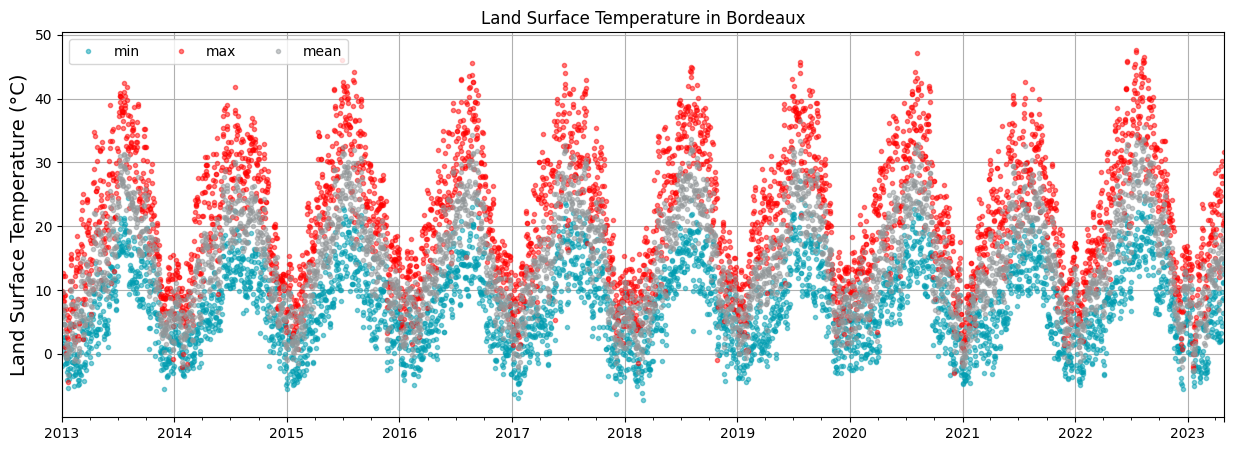

In [11]:
df["daily min"].plot(figsize=(15, 5), style = '.', c="#009db1", alpha=0.5, grid=True)
df["daily max"].plot(figsize=(15, 5), style = '.', c="r", alpha=0.5, grid=True)
df["daily mean"].plot(figsize=(15, 5), style = '.', c="#919698", alpha=0.5, grid=True)

plt.title("Land Surface Temperature in Bordeaux")
plt.legend(["min", "max", "mean", "climatology"], ncol=4, loc="upper left")
plt.ylabel('Land Surface Temperature (°C)', fontsize=14)
plt.show()

### Calculate positive anomaly


In [12]:
# Add the cumulative positive anomaly
backward_average_window_size = 10

# Calculate the backward average
df["rolling mean"] = df["daily mean"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1
).mean()[backward_average_window_size - 1:]

# Calculate the climatology
df["doy"] = df.index.dayofyear
df["climatology"] = df.groupby("doy")["rolling mean"].transform("mean")

# Calculate the anomaly
df["anomaly"] = df["rolling mean"] - df["climatology"]

# Calculate the yearly positive anomaly
df["year"] = df.index.year
df["positive_cumsum"] = df.groupby("year")["anomaly"].transform(lambda x: x.clip(lower=0).cumsum())

### Plot the cumulative positive anomaly

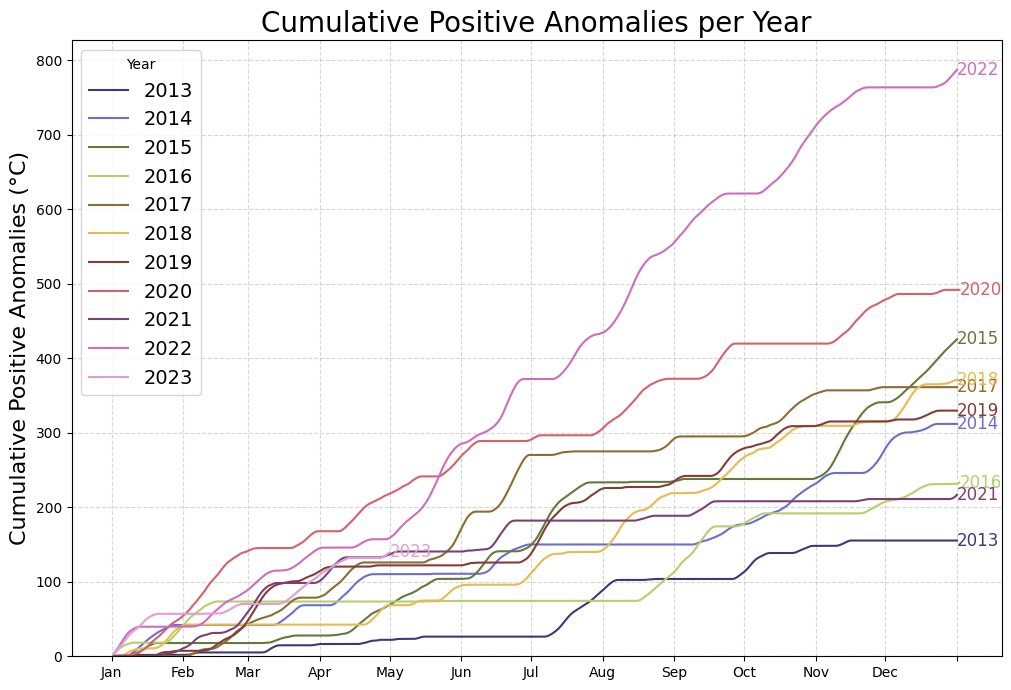

In [14]:
years = df["year"].unique()
colors = cm.tab20b(np.linspace(0, 1, len(years)))

# plot each year with different colors
plt.figure(figsize=(12, 8))
for year, color in zip(years, colors):
    df_subset = df[df["year"] == year].set_index("doy")["positive_cumsum"]
    ax = df_subset.plot(color=color, label=year)
    ax.text(df_subset.index[-1], df_subset.iloc[-1], str(year), color=color, fontsize=12, va='center', ha='left')

# format the figure
ax.set_ylim(bottom=0)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.set_xticks(ax.get_xticks())  # Ensure ticks are set before setting tick labels
tick_labels = [item.get_text() for item in ax.get_xticklabels()]
if tick_labels[-1] == 'Jan':
    tick_labels[-1] = ''
ax.set_xticklabels(tick_labels)

plt.legend(title='Year', loc='upper left', fontsize=14)
plt.title('Cumulative Positive Anomalies per Year', fontsize=20)
plt.ylabel('Cumulative Positive Anomalies (°C)', fontsize=16)
plt.xlabel('')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 1.2 Estimate the Heat index based on the Excess Heat Factor

### 1.2.1 Detect the Heatwaves using the Excess Heat Factor
The Excess Heat Factor (EHF) is a method developed by Nairn & Fawcett in 2014, which identifies heatwaves by examining both maximum and minimum temperatures, as well as short- and long-term anomalies. The EHF is caluclated by multiplying the deviation of the three day average from the climatology with the deviation of the recent temperature from the preceding thirty days. This multiplication of two temperature differences results in a unit of °C². The squared unit amplifies the result, meaning that when both anomalies are high, the EHF value increases substantially.For further information, refer to the publication via [Nairn & Fawcett in 2014](https://doi.org/10.3390/ijerph120100227 ).

In [15]:
# Step 1: Calculate the Excess Heat Index : (T(i) + T(i-1) + T(i-2)) / 3 - T95
T95 = df['daily mean'].quantile(0.95)
df['EHI'] = df['daily mean'].rolling(window=3, min_periods=1).mean() - T95

# Step 2: Calculate the EHIaccl: EHIaccl = (T(i) + T(i-1) + T(i-2)) / 3 - (T(i-3) + ... + T(i-33)) / 30
df['3_day_mean'] = df['daily mean'].rolling(window=3, min_periods=1).mean()
df['30_day_mean'] = df['daily mean'].rolling(window=30, min_periods=1).apply(lambda x: x[:-3].mean(), raw=False)
df['EHIaccl'] = df['3_day_mean'] - df['30_day_mean']

# Step 3: Calculate the Excess Heat Factor (EHF): EHF = EHIsig * max(1, EHIaccl)
df['EHF'] = df['EHI'] * df['EHIaccl'].apply(lambda x: max(1, x))

# Step 4: Identify heatwaves: defined as a period of at least 3 consecutive days with EHF > 0
df['heatwave'] = False
for i in range(2, len(df)):
    if df['EHF'].iloc[i] > 0 and df['EHF'].iloc[i-1] > 0 and df['EHF'].iloc[i-2] > 0:
        df.loc[df.index[i], 'heatwave'] = True
        df.loc[df.index[i-1], 'heatwave'] = True
        df.loc[df.index[i-2], 'heatwave'] = True

df.head()

,daily min,daily max,gap_filled,daily mean,rolling mean,doy,climatology,anomaly,year,positive_cumsum,EHI,3_day_mean,30_day_mean,EHIaccl,EHF,heatwave
2013-01-01,1.689944,9.885899,False,5.787921,NaN,1,6.610669,NaN,2013,NaN,-22.109171,5.787921,NaN,NaN,-22.109171,False
2013-01-02,-1.872304,8.964494,True,3.546095,NaN,2,6.334377,NaN,2013,NaN,-23.230084,4.667008,NaN,NaN,-23.230084,False
2013-01-03,0.584775,12.709607,False,6.647191,NaN,3,6.028072,NaN,2013,NaN,-22.570023,5.327069,NaN,NaN,-22.570023,False
2013-01-04,7.024494,12.255731,True,9.640113,NaN,4,5.816547,NaN,2013,NaN,-21.285960,6.611133,5.787921,0.823212,-21.285960,False
2013-01-05,5.863483,9.577303,False,7.720393,NaN,5,5.564633,NaN,2013,NaN,-19.894527,8.002566,4.667008,3.335557,-66.359337,False


### 1.2.2 Find the strongest Heatwaves and extract their characteristics

In [16]:
number_of_heatwaves_to_display = 4

# Create a column to identify groups of consecutive heatwave periods
df['heatwave_group'] = (df['heatwave'] != df['heatwave'].shift()).cumsum()

# Initialize the heatwave list
heatwave_list = []

# Iterate over each group of consecutive heatwave periods
for group, heatwave_data in df[df['heatwave']].groupby('heatwave_group'):
    start_index = heatwave_data.index[0]
    end_index = heatwave_data.index[-1]

    # Calculate heatwave details
    length = len(heatwave_data)
    ehf_sum = heatwave_data['EHF'].sum()
    hottest_day_temp = heatwave_data['daily mean'].max()
    hottest_day = heatwave_data['daily mean'].idxmax()

    # Append to heatwave list
    heatwave_list.append({
        'start_date': start_index.strftime('%Y-%m-%d'),
        'end_date': end_index.strftime('%Y-%m-%d'),
        'length': length,
        'EHF_sum': ehf_sum,
        'hottest_day': hottest_day.strftime('%Y-%m-%d'),
        'hottest_day_temp': hottest_day_temp,
    })
# Convert heatwave list to a DataFrame for easy viewing
heatwave_df = pd.DataFrame(heatwave_list)

# Keep only the hightest EHF sum heatwaves
heatwave_df = heatwave_df.nlargest(number_of_heatwaves_to_display, 'EHF_sum')
heatwave_df.reset_index(drop=True, inplace=True)
heatwave_df

,start_date,end_date,length,EHF_sum,hottest_day,hottest_day_temp
0,2022-07-11,2022-07-21,11,206.592483,2022-07-18,34.249017
1,2022-08-01,2022-08-14,14,159.252066,2022-08-12,35.563567
2,2018-08-02,2018-08-08,7,147.867768,2018-08-05,33.682107
3,2022-06-14,2022-06-20,7,132.547305,2022-06-18,32.920927


# 2. Spatial analysis: Urban Heat Islands mapping

Leveraging Planet's cloud-free high resolution LST data, we can quantify the cumulative positive anomaly for each city pixel. This cumulative anomaly identifies regions within the city that experience the greatest heat intensity over time, offering a clear view of where the UHI effect is strongest.
This process involves several steps:

1.   Data Collection: Collect 20 years historical 1 km temperature data to determine average temperatures (climatology) for the region.
2. Anomaly Calculation: Calculate 100 m daily temperature anomalies by comparing observed temperatures with its climatology.
3. Cumulative Analysis: Add up positive anomalies over the course of the identified heatwave to highlight areas with sustained high temperatures.



In [17]:
# Sensing time of the satellite overpass (13:30 or 01:30)
sensing_time="1330"

# Update the climatology to the correct sensing time
if sensing_time == "1330":
    df["climatology"] = df.groupby("doy")["daily max"].transform("mean")
elif sensing_time == "0130":
    df["climatology"] = df.groupby("doy")["daily min"].transform("mean")

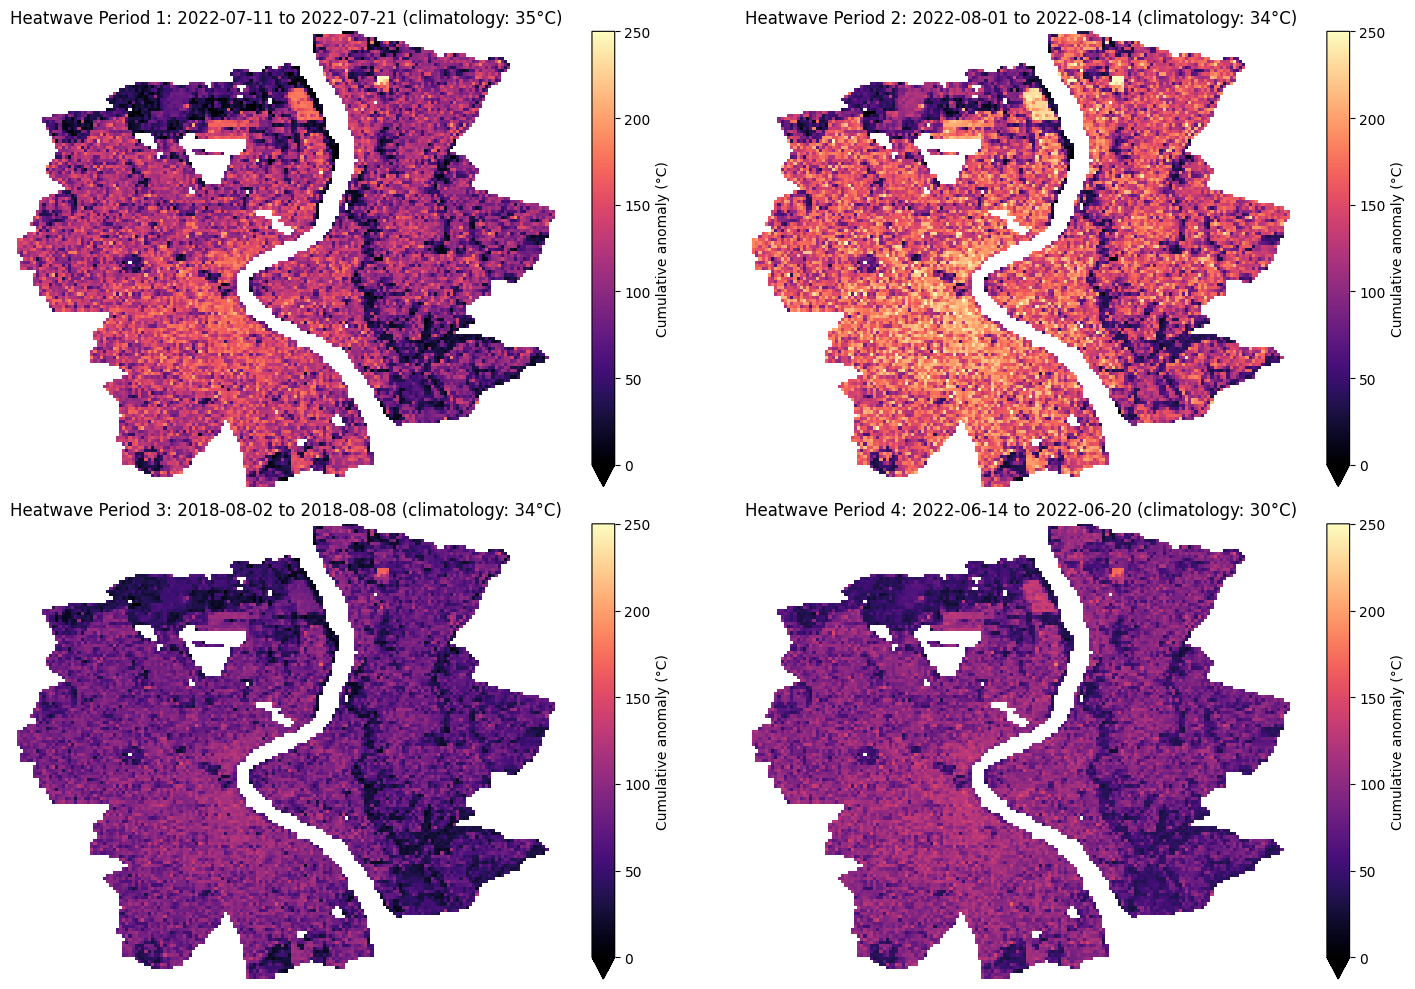

In [19]:
# Assuming heatwave_periods and LST_data are already defined
# Calculate the number of periods and determine the layout for subplots
num_periods = len(heatwave_df)
num_cols = 2
num_rows = (num_periods + 1) // num_cols

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Set the colormap and its properties
cmap = plt.get_cmap('magma')
cmap.set_under('black')
max_cumulative_temp = 250

# Iterate over each heatwave period
for i, heatwave_period in heatwave_df.iterrows():

    # Calculate the base temperature for LST normalization (in Celsius)
    base_temperature = df.loc[heatwave_period["start_date"]:heatwave_period["end_date"]]["climatology"].mean()

    # Define the evalscript for Sentinel Hub request
    evalscript_baseLST = f"""
    //VERSION=3
    sensing_time={sensing_time}
    function setup() {{
        return {{
            input: [{{bands: ["LST", "dataMask"]}}],
            output: [
                {{ id: "LST", bands: 1, sampleType: "FLOAT32" }},
            ],
            mosaicking: "TILE"
        }};
    }}

    // Filter out scenes where the sensing time matches specified sensing time
    function preProcessScenes (collections) {{
        collections.scenes.tiles = collections.scenes.tiles.filter(function (tile) {{
            return tile.dataPath.includes("T"+sensing_time);
        }})
        collections.scenes.tiles.sort((a, b) => new Date(b.date) - new Date(a.date));
        return collections
    }}


    function evaluatePixel(samples) {{
        let totalLST = 0;
        let count = 0;
        samples.forEach(sample => {{
            if (sample.dataMask == 1) {{
                totalLST += (sample.LST / 100) - 273.15 - {base_temperature};
                count++;
            }}
        }});

        return [totalLST === 0 ? NaN : totalLST];
    }}

    """
    request_LST = SentinelHubRequest(
        evalscript=evalscript_baseLST, # the evalscript defined above
        input_data=[
            SentinelHubRequest.input_data(
                DataCollection.define_byoc(collection_100m),
                time_interval=(heatwave_period["start_date"],heatwave_period["end_date"]),
            ),
        ],
        responses=[SentinelHubRequest.output_response("LST", MimeType.TIFF)],
        geometry=aoi,
        resolution=(0.001, 0.001),
        data_folder=".",
        config=config,
    )
    LST_data = request_LST.get_data()[0]

    if num_rows == 1:
        ax = axes[i]
    else:
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

    # Assuming LST_data is a 2D numpy array
    im = ax.imshow(LST_data, cmap=cmap, interpolation='nearest', vmin=0, vmax=max_cumulative_temp)
    ax.set_title(f"Heatwave Period {i+1}: {heatwave_period["start_date"]} to {heatwave_period["end_date"]} (climatology: {int(base_temperature)}°C)")
    cbar = fig.colorbar(im, ax=ax, extend='min')
    cbar.set_label('Cumulative anomaly (°C)')  # Add label to colorbar
    ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()